# Numerical Optimization

This notebook introduces numerical optimization methods in machine learning that minimize loss functions efficiently and stably. The focus is on understanding the intuition, math, and convergence behavior of common optimizers:
- Gradient descent and learning rate schedules
- Stochastic gradient descent (SGD) and mini-batching
- Momentum accelerated gradients
- Adam optimizer (adaptive method)

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
np.random.seed(0)

def quad_fn(x, A, b, c):
    """
    f(x) = 0.5 x^T A x + b^T x + c
    
    x: (n,)
    A: (n, n) symmetric matrix
    b: (n,)
    c: scalar
    """
    return 0.5 * x @ A @ x + b @ x + c

def quad_grad(x, A, b):
    """
    grad_f(x) = A x + b

    x: (n,)
    A: (n, n)
    b: (n,)
    """
    return A @ x + b

def rosenbrock_fn(x, y, a, b):
    """
    f(x, y) = (a - x)^2 + b(y - x^2)^2

    x: scalar
    y: scalar
    a: scalar
    b: scalar
    """
    return (a - x)**2 + b * (y - x**2)**2

def rosenbrock_grad(x, y, a, b):
    """
    grad_f(x, y) = [df/dx, df/dy]
    df/dx = -2(a - x) - 4b x (y - x^2)
    df/dy = 2b (y - x^2)
    
    x: scalar
    y: scalar
    a: scalar
    b: scalar
    """
    dfdx = -2 * (a - x) - 4 * b * x * (y - x**2)
    dfdy = 2 * b * (y - x**2)
    return np.array([dfdx, dfdy])

def saddle_fn(x, y):
    """
    f(x, y) = x^2 - y^2

    x: scalar
    y: scalar
    """
    return x**2 - y**2

def saddle_grad(x, y):
    """
    grad_f(x, y) = [df/dx, df/dy]
    df/dx = 2x
    df/dy = -2y

    x: scalar
    y: scalar
    """
    return np.array([2 * x, -2 * y])

## Gradient Descent

Gradient descent iteratively updates parameters in the opposite direction of the gradient to minimize an objective function:

$$
x_{t+1} = x_t - \eta_t \nabla f(x_t)
$$

where:
- $x_t$ = current parameters
- $\nabla f(x_t)$ = gradient at step $t$
- $\eta_t$ = learning rate (can be constant or scheduled)

There can be different schedules for $\eta_t$ that control convergence speed and stability (constant, inverse time decay, exponential decay).

For this project, we can experiment with different learning rate schedules to study how gradient descent converges toward the global minimum on our example functions (quadratic, rosenbrock, saddle).

In [ ]:
def lr_const(eta):
    """
    eta(t) = eta

    eta: step size
    """
    return lambda t: eta

def lr_time_decay(eta0, decay):
    """
    eta(t) = eta0 / (1 + decay * t)

    eta0: initial step size
    decay: rate of decay over time
    """
    return lambda t: eta0 / (1.0 + decay * t)

def lr_exp_decay(eta0, gamma):
    """
    eta(t) = eta0 * (gamma ** t)

    eta0: initial step size
    gamma: exponential rate of decay
    """
    return lambda t: eta0 * (gamma ** t)

def gd_step_fn(lr_schedule):
    """
    Returns the step function based on the learning rate schedule
    
    lr_schedule: function that determines the learning rate over time
    """
    t = 0
    def step(x, gradient):
        nonlocal t
        eta = lr_schedule(t)
        t += 1
        return x - eta * gradient

    return step

def run_gd(x0, f, grad, step_fn, steps):
    """
    Run gradient descent on a given function.

    Params:
        x0: (n,) initial point
        f: function to minimize
        grad: function that determines the gradient
        step_fn: function that computes the next step based on the current point and gradient
        steps: total number of steps

    Returns:
        xs: points at each step of the descent
        fx: outputs corresponding to each step of the descent
    """
    x = x0.copy()
    xs, fx = [x.copy()], [f(x)]
    for _ in range(steps):
        g = grad(x)
        x = step_fn(x, g)
        xs.append(x.copy())
        fx.append(f(x))
    return np.array(xs), np.array(fx)

def plot_contours_with_path(f, xs, xlim=(-2, 2), ylim=(-2, 2), levels=40, title=None):
    """
    Plot contour lines of a 2D function with an optimization trajectory.

    f: function to minimize
    xs: (T+1, 2) array of points visited during optimization
    xlim: (min, max) range for x-axis
    ylim: (min, max) range for y-axis
    levels: number of contour levels
    title: optional plot title
    """
    xlim, ylim = (-2, 2), (-2, 2)
    xx = np.linspace(*xlim, 300)
    yy = np.linspace(*ylim, 300)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.stack([XX.ravel(), YY.ravel()], axis=1)
    ZZ = np.array([f(p) for p in grid]).reshape(XX.shape)

    plt.figure(figsize=(5.2, 4.6))
    cs = plt.contour(XX, YY, ZZ, levels=levels)
    plt.clabel(cs, inline=True, fontsize=7)
    plt.plot(xs[:, 0], xs[:, 1], marker='o', ms=3, lw=1.5, label='trajectory')
    plt.scatter(xs[0, 0], xs[0, 1], marker='x', s=60, label='start')
    plt.scatter(xs[-1, 0], xs[-1, 1], marker='*', s=80, label='end')
    plt.xlim(xlim); plt.ylim(ylim); plt.gca().set_aspect('equal', 'box')
    plt.title(title)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_loss_curve(fx):
    """
    Plot loss curve from the given loss function values.
    
    fx: (T+1, 1) array of loss function values
    """
    plt.figure()
    plt.plot(fx)
    plt.xlabel("step"); plt.ylabel("f(x)")
    plt.title("Loss curve")
    plt.tight_layout()
    plt.show()

### Quadratic Function with Constant Learning Rate

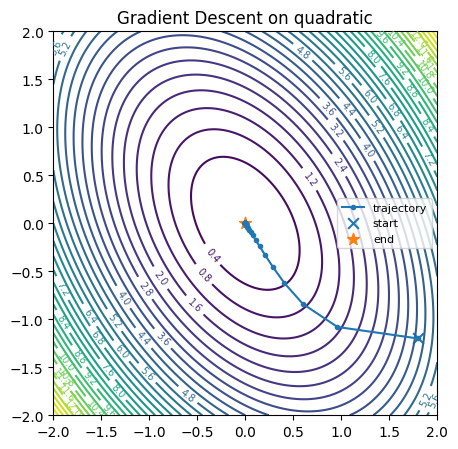

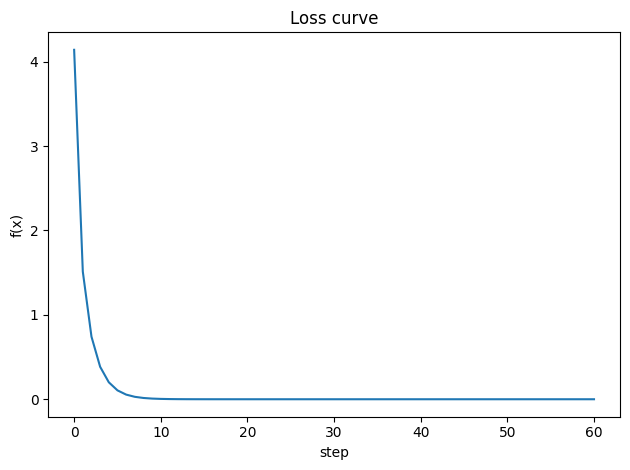

In [24]:
A = np.array([[3.0, 1.0], 
              [1.0, 2.0]])
b = np.array([0.0, 0.0])
c = 0.0

f_quad = lambda x: quad_fn(x, A, b, c)
g_quad = lambda x: quad_grad(x, A, b)

x0 = np.array([1.8, -1.2])
step_fn = gd_step_fn(lr_const(0.2))

# Run gradient descent
xs, fx = run_gd(x0, f_quad, g_quad, step_fn, steps=60)

# Plot contours and loss curve
plot_contours_with_path(f_quad, xs, title="Gradient Descent on quadratic")
plot_loss_curve(fx)

### Quadratic Function with Time Decay Learning Rate

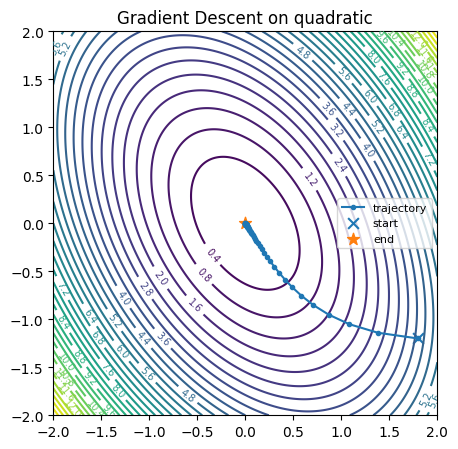

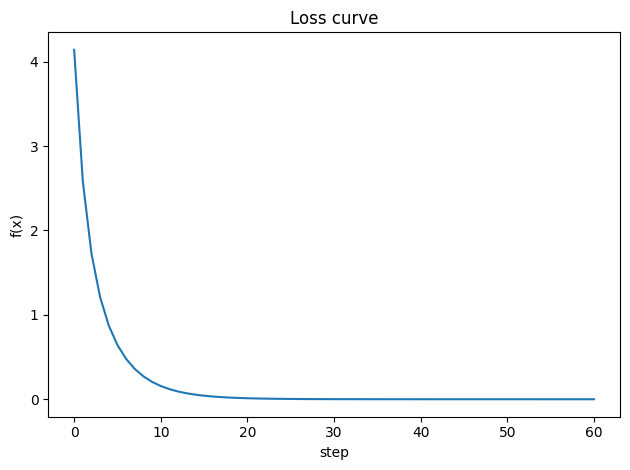

In [57]:
A = np.array([[3.0, 1.0], 
              [1.0, 2.0]])
b = np.array([0.0, 0.0])
c = 0.0

f_quad = lambda x: quad_fn(x, A, b, c)
g_quad = lambda x: quad_grad(x, A, b)

x0 = np.array([1.8, -1.2])
step_fn = gd_step_fn(lr_time_decay(eta0=0.1, decay=1e-2))

# Run gradient descent
xs, fx = run_gd(x0, f_quad, g_quad, step_fn, steps=60)

# Plot contours and loss curve
plot_contours_with_path(f_quad, xs, title="Gradient Descent on quadratic")
plot_loss_curve(fx)

### Quadratic Function with Exponential Decay Learning Rate

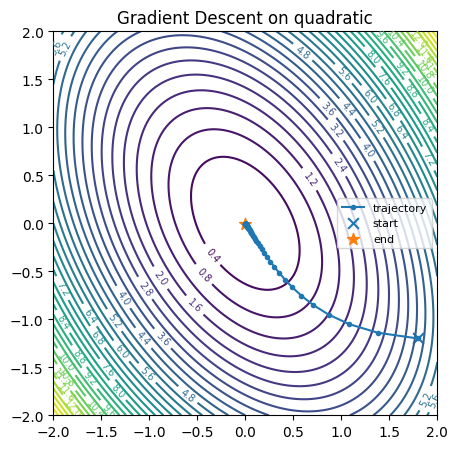

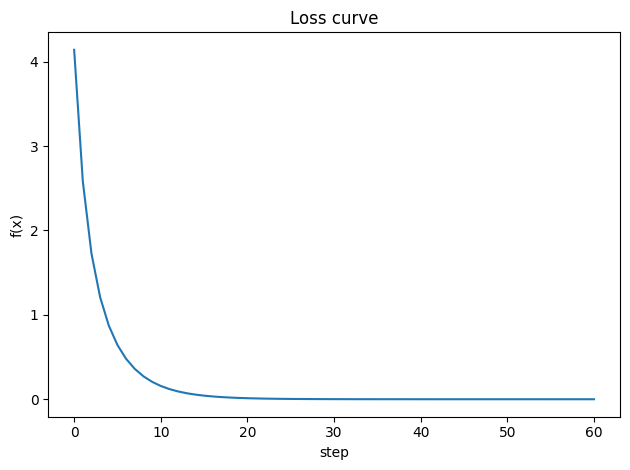

In [58]:
A = np.array([[3.0, 1.0], 
              [1.0, 2.0]])
b = np.array([0.0, 0.0])
c = 0.0

f_quad = lambda x: quad_fn(x, A, b, c)
g_quad = lambda x: quad_grad(x, A, b)

x0 = np.array([1.8, -1.2])
step_fn = gd_step_fn(lr_exp_decay(eta0=0.1, gamma=0.99))

# Run gradient descent
xs, fx = run_gd(x0, f_quad, g_quad, step_fn, steps=60)

# Plot contours and loss curve
plot_contours_with_path(f_quad, xs, title="Gradient Descent on quadratic")
plot_loss_curve(fx)

### Rosenbrock Case Study

Rosenbrock is a classic benchmark in optimization because, for certain parameters (e.g. $a = 1, b = 100$), the global minimum at $(x, y) = (1, 1)$ lies in a curved, narrow valley that gradient descent has difficulty reaching.

$$
f(x, y) = (a - x)^2 + b (y - x^2)^2
$$

This is because:
- the function is ill-conditioned with the curvature being steep in one direction and shallow in another (hard convex)
- gradient descent tends to zig-zag across the valley overshooting with large learning rates
- with small learning rates, it avoids divergence but makes painfully slow progress toward the minimum

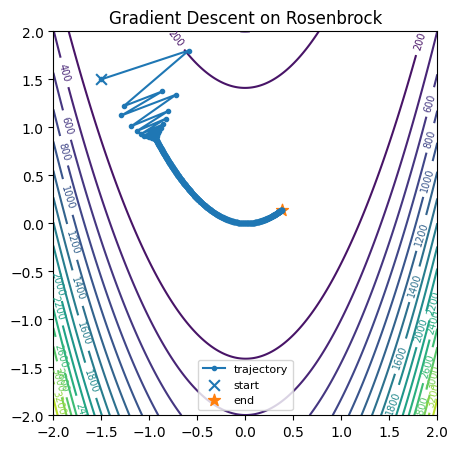

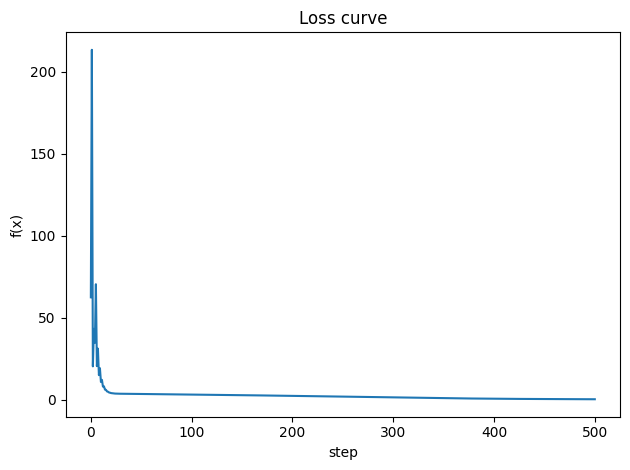

In [43]:
a, b = 1.0, 100.0
f_ros = lambda x: rosenbrock_fn(x[0], x[1], a, b)
g_ros = lambda x: rosenbrock_grad(x[0], x[1], a, b)

x0 = np.array([-1.5, 1.5])
step_fn = gd_step_fn(lr_const(2e-3)) 

# Run gradient descent
xs, fx = run_gd(x0, f_ros, g_ros, step_fn, steps=500)

# Plot contours and loss curve
plot_contours_with_path(f_ros, xs, xlim=(-2, 2), ylim=(-1, 3), levels=20, title="Gradient Descent on Rosenbrock")
plot_loss_curve(fx)

### Saddle Case Study

The saddle function has a stationary point at $(0, 0)$ where the gradient vanishes, but it is not a minimum (there is no minimum, it's not convex). The Hessian is $\nabla^2 f(0, 0) = \text{diag}(2, -2)$, which is indefinite (one positive, one negative eigenvalue) that indicates the point is in a saddle (positive definite means local minimum).

$$
f(x, y) = x^2 - y^2
$$

Gradient descent struggles because:
- The point where the gradient is zero is not necessarily the minimum, so plain GD takes no step and stalls.
- The update only uses the gradient without second-order info, so no curvature cue.

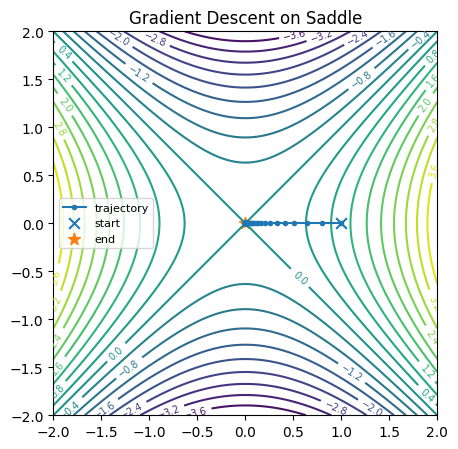

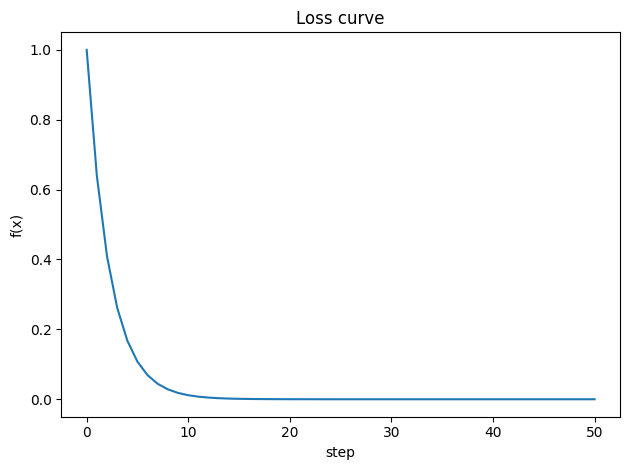

In [50]:
f_sad = lambda v: saddle_fn(v[0], v[1])
g_sad = lambda v: saddle_grad(v[0], v[1])

x0 = np.array([1.0, 0.0])
step_fn = gd_step_fn(lr_const(0.1))

# Run gradient descent
xs, fx = run_gd(x0, f_sad, g_sad, step_fn, steps=50)

# Plot contours and loss curve
plot_contours_with_path(f_sad, xs, xlim=(-2, 2), ylim=(-2, 2), levels=20, title="Gradient Descent on Saddle")
plot_loss_curve(fx)

## Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent is a variant of gradient descent used when the objective can be written as an average of many terms:

$$
f(x) = \frac{1}{N} \sum_{i=1}^N f_i(x).
$$

Instead of computing the full gradient at each step, SGD samples one term at random and uses only its gradient:

$$
x_{t+1} = x_t - \eta_t \nabla f_{i_t}(x_t).
$$

where:
- $x_t$ = current parameters
- $f_{i_t}$ = one randomly chosen component function from the sum
- $\nabla f_{i_t}(x_t)$ = gradient of that component at $x_t$
- $\eta_t$ = learning rate (can be constant or scheduled)

This stochastic update is an unbiased estimate of the full gradient:

$$
\mathbb{E}[\nabla f_{i_t}(x_t)] = \frac{1}{N} \sum_{i=1}^N \nabla f_i(x) = \nabla f(x_t)
$$

but introduces variance that makes the path noisy.

In practice, SGD is used because it avoids the cost of computing the full gradient on all $N$ terms at every step (in the linear regression notebook, computing the gradient involved the entire dataset $X$).
- Using a single sample per update is the cheapest but also the noisiest.  
- Using a mini-batch reduces variance while still being cheaper than full-batch gradient descent and is the standard choice.

### SGD on Least Squares Regression

Least squares regression is a canonical example for SGD since the loss is a finite-sum. Given data points $(x_i, y_i)$ with $x_i \in \mathbb{R}^d$, $y_i \in \mathbb{R}$, the objective is:

$$
f(w) = \frac{1}{2N} \sum_{i=1}^N (x_i^T w - y_i)^2
$$

where:
- $w$ = parameter vector  
- each term $f_i(w) = \frac{1}{2}(x_i^T w - y_i)^2$ corresponds to one data point

The full gradient is:

$$
\nabla f(w) = \frac{1}{N} \sum_{i=1}^N (x_i^T w - y_i) x_i
$$

SGD instead samples one index $i_t$ at random and updates:

$$
w_{t+1} = w_t - \eta_t (x_{i_t}^T w_t - y_{i_t}) x_{i_t}
$$

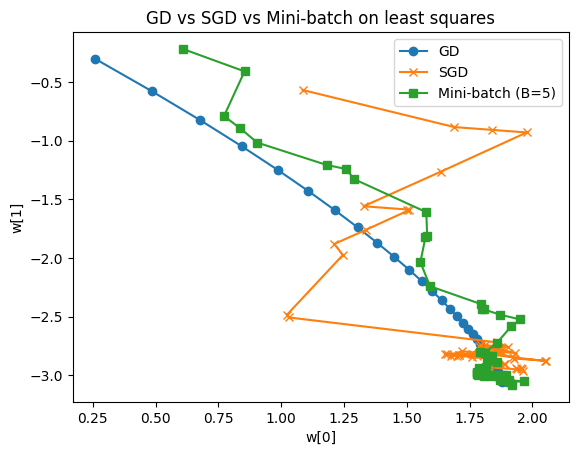

In [ ]:
N, d = 20, 2
X = np.random.randn(N, d)
true_w = np.array([2.0, -3.0])
y = X @ true_w + 0.5 * np.random.randn(N)

# Full gradient
def grad_full(w):
    return (X.T @ (X @ w - y)) / N

# Stochastic gradient (one random sample)
def grad_sgd(w, i):
    return (X[i].T * (X[i] @ w - y[i]))

# Mini-batch gradient (average over a small random subset)
def grad_minibatch(w, I):
    return (X[I].T @ (X[I] @ w - y[I])) / len(I)

# Run GD
w_gd = np.zeros(d)
gd_traj = []
for _ in range(50):
    w_gd -= 0.1 * grad_full(w_gd)
    gd_traj.append(w_gd.copy())

# Run SGD
w_sgd = np.zeros(d)
sgd_traj = []
for _ in range(50):
    i = np.random.randint(N)
    w_sgd -= 0.1 * grad_sgd(w_sgd, i)
    sgd_traj.append(w_sgd.copy())

# Run mini-batch SGD
batch_size = 5
w_mb = np.zeros(d)
mb_traj = []
for _ in range(50):
    I = np.random.choice(N, batch_size, replace=False)
    w_mb -= 0.1 * grad_minibatch(w_mb, I)
    mb_traj.append(w_mb.copy())

# Plot parameter trajectories
gd_traj = np.array(gd_traj)
sgd_traj = np.array(sgd_traj)
mb_traj = np.array(mb_traj)

plt.plot(gd_traj[:,0], gd_traj[:,1], 'o-', label="GD")
plt.plot(sgd_traj[:,0], sgd_traj[:,1], 'x-', label="SGD")
plt.plot(mb_traj[:,0], mb_traj[:,1], 's-', label=f"Mini-batch (B={batch_size})")
plt.xlabel("w[0]"); plt.ylabel("w[1]")
plt.legend(); plt.title("GD vs SGD vs Mini-batch on least squares")
plt.show()

### Saddle Case Study

Let's revisit the saddle function and see why SGD is less likely to get stuck at a saddle:

$$
f(x, y) = x^2 - y^2, \qquad \nabla f(x, y) = (2x, -2y)
$$

If we use plain gradient descent and start at $(0, 0)$, the gradient vanishes and descent never moves. Even near $(0, 0)$, the updates can shrink, so progress is slow and unstable.

To simulate stochastic gradient descent (SGD), we add small random noise to the gradient at each step:

$$
g_t(x, y) = (2x, -2y) + \epsilon_t, \qquad \epsilon_t \sim \mathcal{N}(0, \sigma^2 I)
$$

With this noisy update rule, the iterates no longer freeze at the saddle. The random kicks push the parameters around and eventually away from $(0, 0)$.

In real applications, the "noise" comes naturally from sampling data points or mini-batches. Here, we add it explicitly to illustrate how stochasticity helps escape saddle regions.


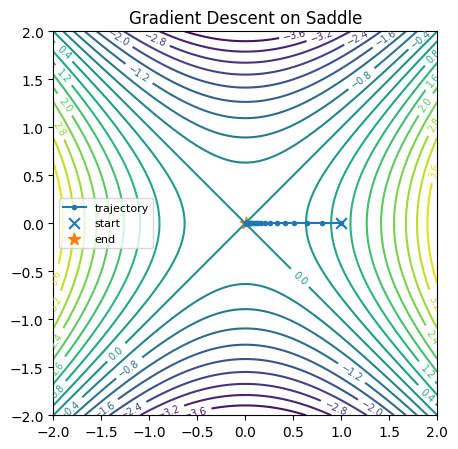

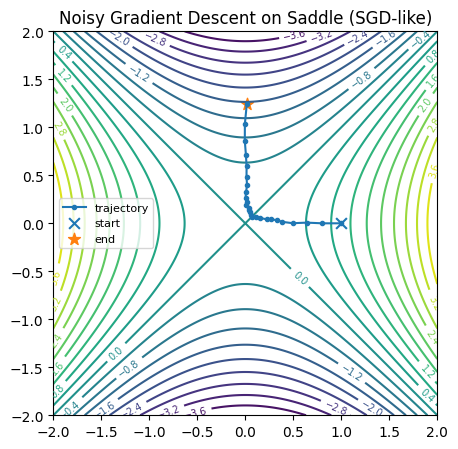

In [ ]:
gd_step = gd_step_fn(lr_const(0.1))

def noisy_gd_step_fn(lr, sigma):
    def step(x, g):
        g_noisy = g + np.random.normal(scale=sigma, size=2)
        return x - lr(0) * g_noisy
    return step

# Run GD
x0 = np.array([1.0, 0.0])
xs_gd, fx_gd = run_gd(x0, f_sad, g_sad, gd_step, steps=25)
plot_contours_with_path(f_sad, xs_gd, levels=20, title="Gradient Descent on Saddle")

# Run noisy GD (SGD-like)
noisy_step = noisy_gd_step_fn(lr_const(0.1), sigma=0.1)
xs_noisy, fx_noisy = run_gd(x0, f_sad, g_sad, noisy_step, steps=25)
plot_contours_with_path(f_sad, xs_noisy, levels=20, title="Noisy Gradient Descent on Saddle (SGD-like)")


## Momentum Accelerated Gradients

Momentum modifies gradient descent by keeping an exponential moving average of past gradients (“velocity”). At each step with learning rate $\eta$ and momentum parameter $\beta \in [0, 1)$:

$$
v_t = \beta v_{t-1} + (1 - \beta)\nabla f(x_{t-1}), \qquad
x_t = x_{t-1} - \eta v_t
$$

This smooths out oscillations and accelerates movement in directions where gradients are consistent.

### Rosenbrock Case Study

The Rosenbrock function is difficult for plain gradient descent because its minimum lies in a long, narrow valley. GD tends to zig-zag across the walls of the valley, which slows convergence.

With momentum, the velocity averages out the back-and-forth updates and builds inertia along the valley floor. As a result, the descent follows the curved path toward $(1, 1)$ more directly and reach the minimum faster than plain GD.

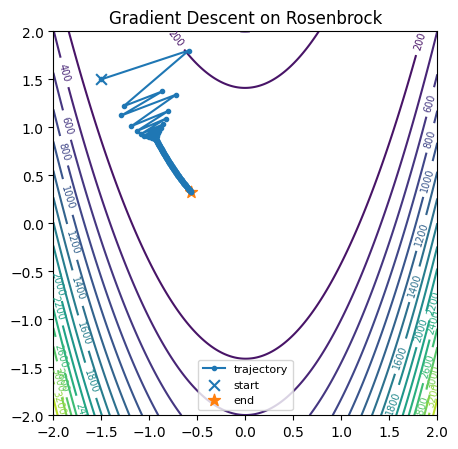

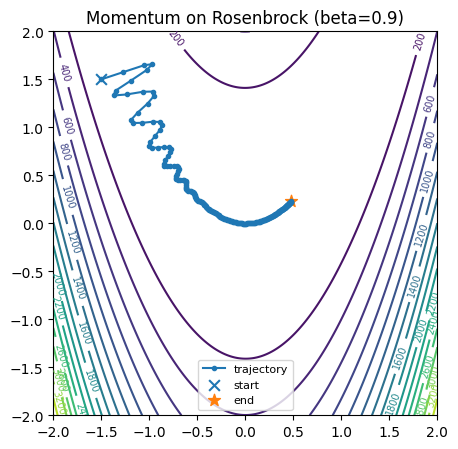

In [ ]:
a, b = 1.0, 100.0
f_ros = lambda x: rosenbrock_fn(x[0], x[1], a, b)
g_ros = lambda x: rosenbrock_grad(x[0], x[1], a, b)

# Momentum step function
def momentum_step_fn(lr, beta=0.9):
    v = None
    def step(x, g):
        nonlocal v
        if v is None:
            v = np.zeros_like(x)
        v = beta * v + (1.0 - beta) * g
        return x - lr(0) * v
    return step

x0 = np.array([-1.5, 1.5])
num_steps = 200

# Run GD
gd_step = gd_step_fn(lr_const(2e-3))
xs_gd, fx_gd = run_gd(x0, f_ros, g_ros, gd_step, steps=num_steps)
plot_contours_with_path(f_ros, xs_gd, xlim=(-2, 2), ylim=(-1, 3), levels=20, title="Gradient Descent on Rosenbrock")

# Run GD with Momentum
mom_step = momentum_step_fn(lr_const(5e-3), beta=0.9)
xs_mom, fx_mom = run_gd(x0, f_ros, g_ros, mom_step, steps=num_steps)
plot_contours_with_path(f_ros, xs_mom, xlim=(-2, 2), ylim=(-1, 3), levels=20, title="Momentum on Rosenbrock (beta=0.9)")

## Adam Optimizer

Adam (Adaptive Moment Estimation) combines two ideas. Like momentum, it smooths updates by averaging past gradients. It also adapts step sizes by keeping a running average of squared gradients. Large gradients are scaled down, and small gradients are scaled up. This makes Adam both stable and fast, and works well with some tuning.

Adam keeps track of two moving averages with $\beta_1$ and $\beta_2$ as weights for the first and second moments:

**First moment (gradients)**
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)\nabla f(x_{t-1})
$$

**Second moment (squared gradients)**
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2)(\nabla f(x_{t-1}))^2
$$

Because both moving averages start at zero, they are biased toward smaller values in early steps.  
To fix this, Adam uses bias-corrected estimates:
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \qquad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

The parameter update is:
$$
x_t = x_{t-1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

### Rosenbrock Case Study

With Adam, the optimizer not only smooths the updates like momentum but also adapts the step size in each coordinate. On Rosenbrock, this means large gradients across the valley walls are scaled down, while small gradients along the valley floor are scaled up. The result is faster progress through the curved valley and a more efficient path to the minimum at $(1, 1)$ compared to both plain GD and momentum.


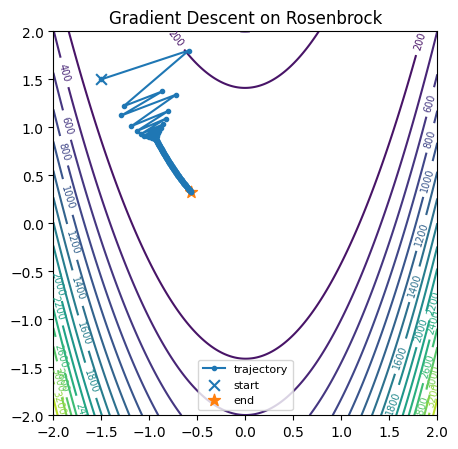

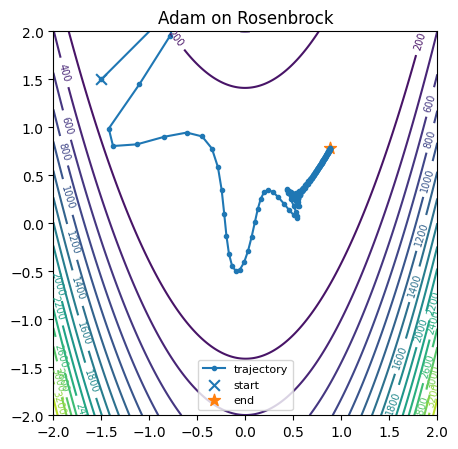

In [111]:
a, b = 1.0, 100.0
f_ros = lambda x: rosenbrock_fn(x[0], x[1], a, b)
g_ros = lambda x: rosenbrock_grad(x[0], x[1], a, b)

def adam_step_fn(lr, beta1=0.9, beta2=0.99, eps=1e-8):
    m, v, t = None, None, 0
    def step(x, g):
        nonlocal m, v, t
        if m is None:
            m, v = np.zeros_like(x), np.zeros_like(x)
        t += 1
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        return x - lr(0) * m_hat / (np.sqrt(v_hat) + eps)
    return step

x0 = np.array([-1.5, 1.5])
num_steps = 200

# Run GD
gd_step = gd_step_fn(lr_const(2e-3))
xs_gd, fx_gd = run_gd(x0, f_ros, g_ros, gd_step, steps=num_steps)
plot_contours_with_path(f_ros, xs_gd, xlim=(-2, 2), ylim=(-1, 3), levels=20, title="Gradient Descent on Rosenbrock")

# Run Adam
adam_step = adam_step_fn(lr_const(0.8))
xs_adam, fx_adam = run_gd(x0, f_ros, g_ros, adam_step, steps=num_steps)
plot_contours_with_path(f_ros, xs_adam, xlim=(-2,2), ylim=(-1,3), levels=20, title="Adam on Rosenbrock")